In [1]:
import numpy as np
import pandas as pd
import subprocess
from Bio import pairwise2
import tqdm
tlp = "/Users/john/data/deaminase/{}"
df = pd.read_json(tlp.format("index_af.json"),lines=True)
limit =25
sequences=[ s for s in df["uniprotSequence"].values][:limit]
accessions=[ s for s in df["uniprotAccession"].values][:limit]
# 初始化相似度矩阵
n = len(sequences)
gnames=[v for v in df["uniprotId"].values][:limit]

def simseq(i, j):
    s1, s2 =sequences[i],sequences[j]
    alignments = pairwise2.align.globalxx(s1, s2)
    alignment = alignments[0]
    score = alignment[2]
    similarity = score / max(len(s1), len(s2))
    return similarity


def simpdb(i, j):
    pdb1 = tlp.format(f"pdbs/{accessions[i]}.pdb")
    pdb2 = tlp.format(f"pdbs/{accessions[j]}.pdb")
    cmd = ['TMalign', pdb1, pdb2]
    result = subprocess.run(cmd, capture_output=True, text=True)
    output = result.stdout
    for line in output.split('\n'):
        if 'TM-score=' in line and 'if normalized by length of Chain_2' in line:
            return line.strip().split()[1]
    return 0
    


similarity_matrix = np.zeros((n, n))

# 计算两两之间的相似度
for i in tqdm.tqdm(range(n)):
    for j in range(i, n):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            similarity=simseq(i,j)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

# 打印相似度矩阵
correlations = pd.DataFrame(data={gnames[i]:similarity_matrix[:][i] for i, g in enumerate(gnames)})
correlations.index=gnames
correlations

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.00it/s]


,CDD_BACSU,CDD_HUMAN,CDD_MYCGE,CDD_MYCPI,CDD_MOUSE,CDD_MYCPN,CDD_YEAST,CDD_SCHPO,CDD_DICDI,CDD_BACHD,...,CDD_VIBC3,CDD_HAEIE,CDD_HAEIG,CDD_KLEP7,CDD_YERP3,CDD_CROS8,CDD_VIBCB,CDD_ECO24,CDD_ECOHS,CDD_CITK8
CDD_BACSU,1.000000,0.520548,0.411765,0.477941,0.506849,0.426471,0.492958,0.492647,0.503401,0.654412,...,0.267797,0.250000,0.253425,0.251701,0.238095,0.248299,0.254237,0.255102,0.255102,0.248299
CDD_HUMAN,0.520548,1.000000,0.397260,0.452055,0.815068,0.424658,0.472603,0.520548,0.544218,0.479452,...,0.254237,0.267123,0.263699,0.248299,0.248299,0.261905,0.261017,0.251701,0.251701,0.244898
CDD_MYCGE,0.411765,0.397260,1.000000,0.496241,0.376712,0.676692,0.443662,0.451128,0.394558,0.416667,...,0.237288,0.256849,0.253425,0.214286,0.224490,0.231293,0.233898,0.234694,0.238095,0.221088
CDD_MYCPI,0.477941,0.452055,0.496241,1.000000,0.445205,0.496241,0.478873,0.496241,0.448980,0.488722,...,0.230508,0.250000,0.250000,0.227891,0.231293,0.231293,0.244068,0.244898,0.244898,0.238095
CDD_MOUSE,0.506849,0.815068,0.376712,0.445205,1.000000,0.404110,0.465753,0.486301,0.537415,0.486301,...,0.271186,0.246575,0.246575,0.255102,0.251701,0.255102,0.267797,0.255102,0.255102,0.251701
CDD_MYCPN,0.426471,0.424658,0.676692,0.496241,0.404110,1.000000,0.415493,0.458647,0.414966,0.443609,...,0.227119,0.239726,0.239726,0.231293,0.214286,0.221088,0.230508,0.231293,0.231293,0.224490
CDD_YEAST,0.492958,0.472603,0.443662,0.478873,0.465753,0.415493,1.000000,0.514085,0.448980,0.436620,...,0.247458,0.253425,0.253425,0.238095,0.234694,0.234694,0.264407,0.244898,0.241497,0.241497
CDD_SCHPO,0.492647,0.520548,0.451128,0.496241,0.486301,0.458647,0.514085,1.000000,0.469388,0.488722,...,0.237288,0.229452,0.229452,0.231293,0.224490,0.234694,0.244068,0.238095,0.238095,0.227891
CDD_DICDI,0.503401,0.544218,0.394558,0.448980,0.537415,0.414966,0.448980,0.469388,1.000000,0.482993,...,0.257627,0.256849,0.256849,0.258503,0.255102,0.244898,0.261017,0.265306,0.265306,0.248299
CDD_BACHD,0.654412,0.479452,0.416667,0.488722,0.486301,0.443609,0.436620,0.488722,0.482993,1.000000,...,0.257627,0.239726,0.246575,0.248299,0.238095,0.248299,0.250847,0.251701,0.251701,0.248299


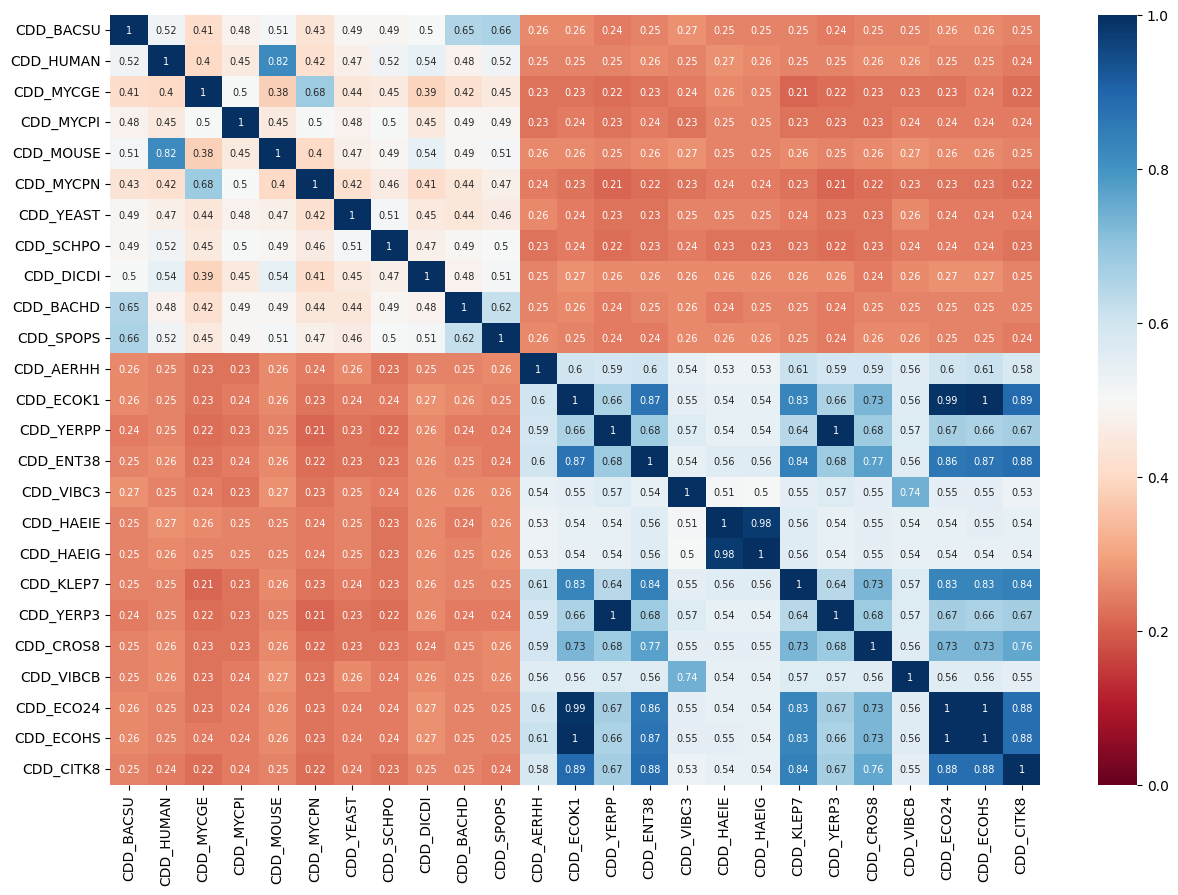

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(15,10))
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0, vmax=1);

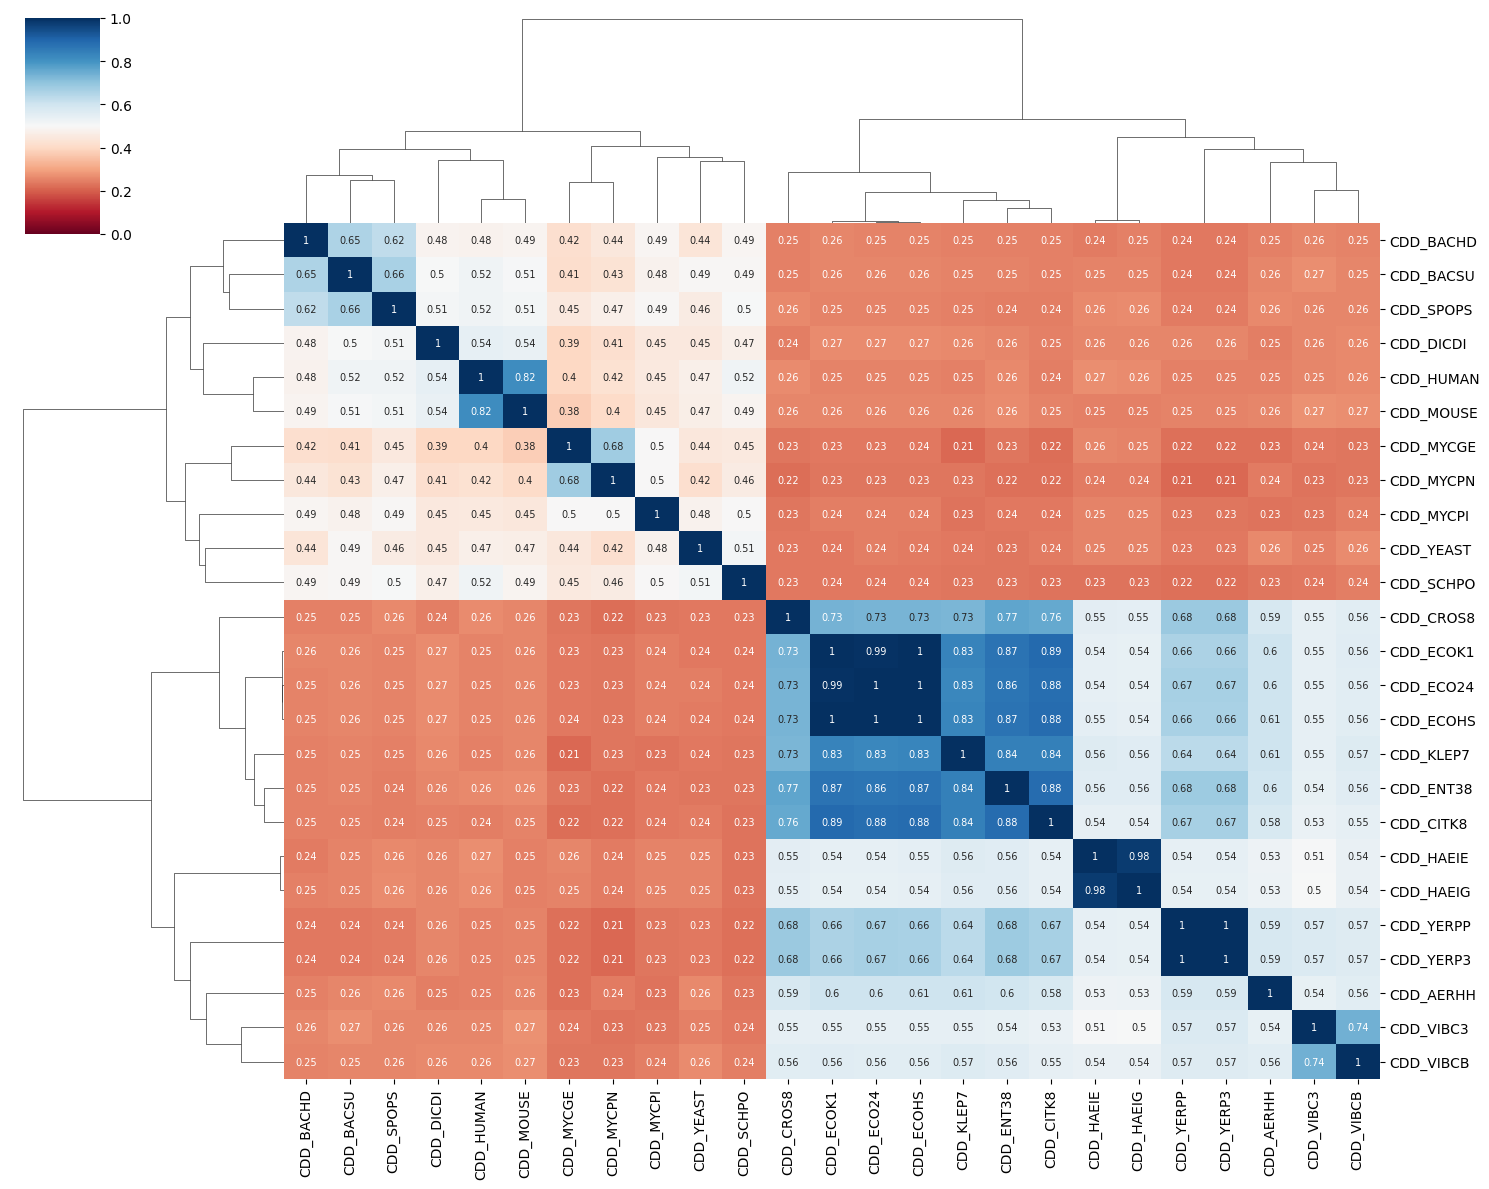

In [3]:
sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=0, vmax=1, figsize=(15,12));

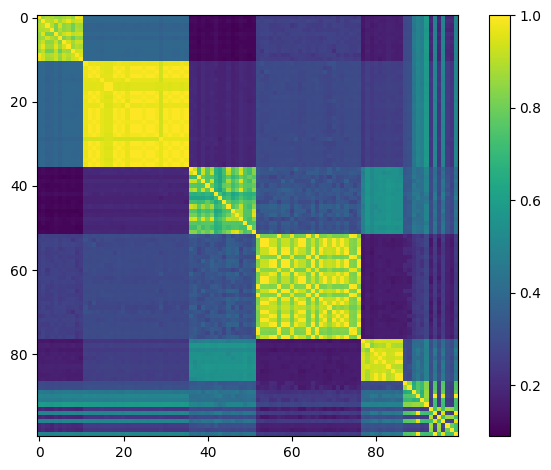

In [29]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(similarity_matrix)
plt.colorbar()
plt.tight_layout()
plt.show()

/var/folders/g3/9kgyg0z54nv7fpxy0pgwx0y80000gn/T/ipykernel_33469/700836823.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')  # 'ward'方法最小化各簇内的方差


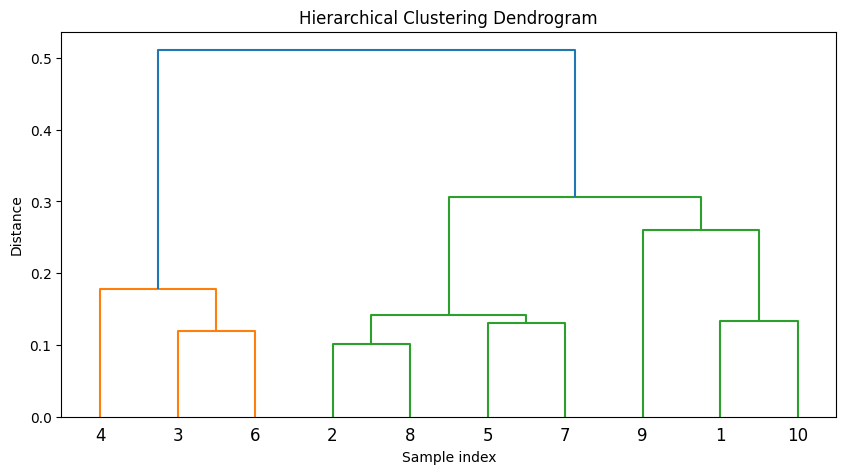

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# 创建示例数据
distance_matrix = 1 - similarity_matrix
# 使用linkage函数进行层次聚类
Z = linkage(distance_matrix, method='ward')  # 'ward'方法最小化各簇内的方差

# 绘制树状图
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=np.arange(1, 11))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [25]:
import numpy as np
from scipy.cluster.hierarchy import linkage, to_tree
from scipy.spatial.distance import pdist

# 转换为树结构
root_node, nodes = to_tree(Z, rd=True)


def get_newick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return f"{leaf_names[node.id]}:{parentdist - node.dist}{newick}"
    else:
        if len(newick) > 0:
            newick = f"): {parentdist - node.dist}{newick}"
        else:
            newick = ");"
        newick = get_newick(node.get_left(), newick, node.dist, leaf_names)
        newick = get_newick(node.get_right(), f",{newick}", node.dist, leaf_names)
        newick = f"({newick}"
        return newick

    
# 生成叶节点名称（假设数据点的索引为叶节点名称）
leaf_names = list(map(str, range(1, len(data) + 1)))

# 生成Newick格式字符串
newick_str = get_newick(root_node, "", root_node.dist, leaf_names)
print("Newick格式字符串:")
print(newick_str)
# 将Newick格式字符串保存到文件
with open("tree.nwk", "w") as file:
    file.write(newick_str)


Newick格式字符串:
((((10:0.13270816515949582,1:0.13270816515949582): 0.12707639680162866,9:0.2597845619611245): 0.045991069733252454,((7:0.13000088538160035,5:0.13000088538160035): 0.011632838356780528,(8:0.10183915946236011,2:0.10183915946236011): 0.039794564276020766): 0.16414190795599606): 0.20509615954282256,((6:0.11910932709070265,3:0.11910932709070265): 0.058234420661132796,4:0.17734374775183545): 0.333528043485364);


In [34]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace

tree = Tree(newick_str)
# 定义样式
def set_node_style(node):
    style = NodeStyle()
#     style["shape"] = "sphere"
    style["size"] = 10
    style["fgcolor"] = "darkred" if node.is_leaf() else "royalblue"
    style["vt_line_color"] = "black"
    style["hz_line_color"] = "black"
    style["vt_line_width"] = 2
    style["hz_line_width"] = 2
    style["vt_line_type"] = 0  # 0 solid, 1 dashed, 2 dotted
    style["hz_line_type"] = 0
    node.set_style(style)

for node in tree.traverse():
    set_node_style(node)
# 定义树的样式
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_scale = False
ts.branch_vertical_margin = 10
ts.mode = "c" # draw tree in circular mode

# 添加节点名称的样式
# for n in tree.traverse():
#     if n.is_leaf():
#         n.add_face(TextFace(n.name, fsize=10, fgcolor="darkred"), column=0, position="branch-right")

# 绘制并显示树
tree.show(tree_style=ts)

In [10]:
df

,entryId,gene,uniprotAccession,uniprotId,uniprotDescription,taxId,organismScientificName,uniprotStart,uniprotEnd,uniprotSequence,...,isReviewed,isReferenceProteome,cifUrl,bcifUrl,pdbUrl,paeImageUrl,paeDocUrl,amAnnotationsUrl,amAnnotationsHg19Url,amAnnotationsHg38Url
0,AF-P19079-F1,cdd,P19079,CDD_BACSU,Cytidine deaminase,224308,Bacillus subtilis (strain 168),1,136,MNRQELITEALKARDMAYAPYSKFQVGAALLTKDGKVYRGCNIENA...,...,True,True,https://alphafold.ebi.ac.uk/files/AF-P19079-F1...,https://alphafold.ebi.ac.uk/files/AF-P19079-F1...,https://alphafold.ebi.ac.uk/files/AF-P19079-F1...,https://alphafold.ebi.ac.uk/files/AF-P19079-F1...,https://alphafold.ebi.ac.uk/files/AF-P19079-F1...,None,None,None
1,AF-P32320-F1,CDA,P32320,CDD_HUMAN,Cytidine deaminase,9606,Homo sapiens,1,146,MAQKRPACTLKPECVQQLLVCSQEAKKSAYCPYSHFPVGAALLTQE...,...,True,True,https://alphafold.ebi.ac.uk/files/AF-P32320-F1...,https://alphafold.ebi.ac.uk/files/AF-P32320-F1...,https://alphafold.ebi.ac.uk/files/AF-P32320-F1...,https://alphafold.ebi.ac.uk/files/AF-P32320-F1...,https://alphafold.ebi.ac.uk/files/AF-P32320-F1...,https://alphafold.ebi.ac.uk/files/AF-P32320-F1...,https://alphafold.ebi.ac.uk/files/AF-P32320-F1...,https://alphafold.ebi.ac.uk/files/AF-P32320-F1...
2,AF-P47298-F1,cdd,P47298,CDD_MYCGE,Cytidine deaminase,243273,Mycoplasma genitalium (strain ATCC 33530 / G-3...,1,130,MKVNLEWIIKQLQMIVKRAYTPFSNFKVACMIIANNQTFFGVNIEN...,...,True,True,https://alphafold.ebi.ac.uk/files/AF-P47298-F1...,https://alphafold.ebi.ac.uk/files/AF-P47298-F1...,https://alphafold.ebi.ac.uk/files/AF-P47298-F1...,https://alphafold.ebi.ac.uk/files/AF-P47298-F1...,https://alphafold.ebi.ac.uk/files/AF-P47298-F1...,None,None,None
3,AF-P47718-F1,cdd,P47718,CDD_MYCPI,Cytidine deaminase,2122,Mycoplasma pirum,1,133,MKEKDIYFQKLNELISNAYVPYSNFRVSCLLLTDGGWFAGVNIENS...,...,True,False,https://alphafold.ebi.ac.uk/files/AF-P47718-F1...,https://alphafold.ebi.ac.uk/files/AF-P47718-F1...,https://alphafold.ebi.ac.uk/files/AF-P47718-F1...,https://alphafold.ebi.ac.uk/files/AF-P47718-F1...,https://alphafold.ebi.ac.uk/files/AF-P47718-F1...,None,None,None
4,AF-P56389-F1,Cda,P56389,CDD_MOUSE,Cytidine deaminase,10090,Mus musculus,1,146,MAQERPSCAVEPEHVQRLLLSSREAKKSAYCPYSRFPVGAALLTGD...,...,True,True,https://alphafold.ebi.ac.uk/files/AF-P56389-F1...,https://alphafold.ebi.ac.uk/files/AF-P56389-F1...,https://alphafold.ebi.ac.uk/files/AF-P56389-F1...,https://alphafold.ebi.ac.uk/files/AF-P56389-F1...,https://alphafold.ebi.ac.uk/files/AF-P56389-F1...,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,AF-C3K8W2-F1,PFLU_0667,C3K8W2,ADE_PSEFS,Adenine deaminase,216595,Pseudomonas fluorescens (strain SBW25),1,317,MYDWLNALPKAELHLHLEGSLEPELLFALAERNKIALPWNDVETLR...,...,True,True,https://alphafold.ebi.ac.uk/files/AF-C3K8W2-F1...,https://alphafold.ebi.ac.uk/files/AF-C3K8W2-F1...,https://alphafold.ebi.ac.uk/files/AF-C3K8W2-F1...,https://alphafold.ebi.ac.uk/files/AF-C3K8W2-F1...,https://alphafold.ebi.ac.uk/files/AF-C3K8W2-F1...,None,None,None
205,AF-C3MBH4-F1,NGR_c34590,C3MBH4,ADE_SINFN,Adenine deaminase,394,Sinorhizobium fredii (strain NBRC 101917 / NGR...,1,324,MTAHLKKAELHCHIEGATPPELALRQARKYSVDTSAIIRDKAYVWE...,...,True,True,https://alphafold.ebi.ac.uk/files/AF-C3MBH4-F1...,https://alphafold.ebi.ac.uk/files/AF-C3MBH4-F1...,https://alphafold.ebi.ac.uk/files/AF-C3MBH4-F1...,https://alphafold.ebi.ac.uk/files/AF-C3MBH4-F1...,https://alphafold.ebi.ac.uk/files/AF-C3MBH4-F1...,None,None,None
206,AF-P53909-F1,AAH1,P53909,ADE_YEAST,Adenine deaminase,559292,Saccharomyces cerevisiae (strain ATCC 204508 /...,1,347,MVSVEFLQELPKCEHHLHLEGTLEPDLLFPLAKRNDIILPEGFPKS...,...,True,True,https://alphafold.ebi.ac.uk/files/AF-P53909-F1...,https://alphafold.ebi.ac.uk/files/AF-P53909-F1...,https://alphafold.ebi.ac.uk/files/AF-P53909-F1...,https://alphafold.ebi.ac.uk/files/AF-P53909-F1...,https://alphafold.ebi.ac.uk/files/AF-P53909-F1...,None,None,None
207,AF-O42912-F1,SPBC16A3.06,O42912,TAD1_SCHPO,tRNA-specific 